In [3]:
import matplotlib.pyplot as plt
import torch
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [4]:
class Normal():
    def __init__(self, mu, std):
        self.mu = mu
        self.std = std
        self.shape = torch.broadcast_shapes(mu.shape, std.shape)
        
    def log_prob(self, x):

        min_std = 1e-6
        std = torch.clamp(self.std, min=min_std)
        return torch.sum(- (x - self.mu)**2 / (2 * std**2) - torch.log(std))
        
    
    def rsample(self):
        return torch.randn(self.shape)*self.std + self.mu
    
normal_instance = Normal(mu=torch.tensor([0.0]), std=torch.tensor([1.0]))

# Displaying the parameters of the created Normal instance
print(f"Normal distribution with mean (mu) = {normal_instance.mu} and standard deviation (std) = {normal_instance.std}")

Normal distribution with mean (mu) = tensor([0.]) and standard deviation (std) = tensor([1.])


In [19]:
class Linear(torch.nn.Module):
    def __init__(self, in_features: int, out_features: int, prior_mu=0.0, prior_sigma=1.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.weight = torch.randn((out_features, in_features))
        self.weight_mean = Parameter(self.weight)
        self.weight_log_std = Parameter(torch.zeros_like(self.weight)-2.)

        self.bias = torch.zeros(out_features)
        self.bias_mean = Parameter(self.bias)
        self.bias_log_std = Parameter(torch.zeros_like(self.bias)-2.)

        self.log_variance = Parameter(torch.tensor(-2.0))

        self.prior_mu = prior_mu
        self.prior_sigma = prior_sigma

        self.epsilon = 1e-6

    def forward(self, input):
        return torch.nn.functional.linear(input, self.weight, self.bias)
    
    def distributions(self):
        weight_dist = Normal(self.weight_mean, torch.exp(self.weight_log_std)+self.epsilon)
        bias_dist = Normal(self.bias_mean, torch.exp(self.bias_log_std)+self.epsilon)
        return (weight_dist, bias_dist)
    
    def variables(self):
        return (self.weight, self.bias)
    
    def sample(self):
        self.weight = self.distributions()[0].rsample()
        self.bias = self.distributions()[1].rsample()
        return
    
    def sample_return(self):
        weight = self.distributions()[0].rsample()
        bias = self.distributions()[1].rsample()
        return weight, bias
                 
    def logq(self):
        # Closed-form KL divergence for Gaussian prior and posterior
        def kl_divergence(mu_q, log_std_q, mu_p, sigma_p):
            sigma_q = torch.exp(log_std_q)
            kl = torch.log(sigma_p / sigma_q) + (sigma_q**2 + (mu_q - mu_p)**2) / (2 * sigma_p**2) - 0.5
            return kl.sum()
        
        kl_weight = kl_divergence(self.weight_mean, self.weight_log_std, self.prior_mu, self.prior_sigma)
        kl_bias = kl_divergence(self.bias_mean, self.bias_log_std, self.prior_mu, self.prior_sigma)
        
        return kl_weight + kl_bias
    
    def logp(self, y_pred, y_true):
        variance = torch.exp(self.log_variance)
        log_likelihood = -0.5 * torch.sum(torch.log(2 * torch.pi * variance) + (y_true - y_pred) ** 2 / variance)
        return log_likelihood
    
    # Stick the landing
    def logq_stl(self):            
        return sum([dist.log_prob(var.detach()) for var, dist in zip(self.variables(), self.distributions())])




In [17]:

class BNN(torch.nn.Module):
    """Bayesian Neural Network with two hidden layers."""
    def __init__(self, input_features, hidden_features1, hidden_features2, output_features):
        super().__init__()
        # Define BayesianLinear layers
        self.layer1 = Linear(input_features, hidden_features1)
        self.layer2 = Linear(hidden_features1, hidden_features2)
        self.layer3 = Linear(hidden_features2, output_features)
        self.relu=torch.nn.ReLU()

        self.log_variance = Parameter(torch.tensor(-2.0))

    def forward(self, x):
        x = self.layer1(x)
        x=self.relu(x)
        x=self.layer2(x)
        x=self.relu(x)
        x=self.layer3(x)
        return x
    
    def sample(self):
        self.layer1.sample()
        self.layer2.sample()
        self.layer3.sample()
        return

    def logq(self):
        return self.layer1.logq()+self.layer2.logq()+self.layer3.logq()
    
    def logp(self, y_pred, y_true):
        variance = torch.exp(self.log_variance)
        log_likelihood = -0.5 * torch.sum(torch.log(2 * torch.pi * variance) + 
                                           (y_true - y_pred) ** 2 / variance)
        return log_likelihood

In [7]:
torch.manual_seed(42)

N = 300  # Number of data points
D_in = 5  # Number of input features
D_out = 1  # Number of output features

# Generate random input data with 5 features
X = torch.randn(N, D_in)

# Define weights and bias for the linear combination, simulating a "true" underlying model
true_weights = torch.tensor([1.5, -2.0, 1.0, 0.5, -0.5]).unsqueeze(1)  # Shape (D_in, 1) to match D_in features
true_bias = torch.tensor([0.5])

# Generate output data: y = Xw + b + noise
# where 'noise' is Gaussian noise added to introduce variability
noise = torch.randn(N, D_out) * 0.5  # Scale noise to control the noise level
Y = X @ true_weights + true_bias + noise

# Normalize the features
X_mean = X.mean(0, keepdim=True)
X_std = X.std(0, keepdim=True)
x = (X - X_mean) / X_std

# Normalize the output
Y_mean = Y.mean()
Y_std = Y.std()
y = (Y - Y_mean) / Y_std

In [8]:
def plot_fit(y, y_est):
    plt.figure('Fit')
    plt.clf()
    plt.plot([-4, 4], [-4, 4], color='k', alpha=0.1)
    i = torch.argsort(y[:,0])
    plt.plot(y, y_est, '.', alpha=0.2)
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    plt.axis('square')
    mdock.drawnow()

def plot_elbo(elbo):
    plt.figure('ELBO')
    plt.clf()
    plt.plot(elbo, '.', alpha=.2, markeredgecolor='none')
    plt.grid(True)

def plot_logp(logp):
    plt.figure('logP')
    plt.clf()
    plt.plot(logp, '.', alpha=.2, markeredgecolor='none')
    plt.grid(True)
    plt.ylim([-60, -40])

def plot_logq(logq):
    plt.figure('logQ (negative entropy)')
    plt.clf()
    plt.plot(logq, '.', alpha=.2, markeredgecolor='none')
    plt.grid(True)

def improved_plot_fit(x, y_actual, y_predicted):
    # Convert tensors to numpy arrays for plotting
    x_np = x.squeeze().numpy()
    y_actual_np = y_actual.squeeze().numpy()
    y_predicted_np = y_predicted.squeeze().detach().numpy()  # Detach for no grad

    # Scatter plot of actual vs predicted values
    plt.scatter(x_np, y_actual_np, label='Actual', alpha=0.5, marker='o')
    plt.scatter(x_np, y_predicted_np, label='Predicted', alpha=0.5, marker='x')

    # Line of perfect fit
    min_val = min(y_actual_np.min(), y_predicted_np.min())
    max_val = max(y_actual_np.max(), y_predicted_np.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Fit')

    # Labels and legend
    plt.xlabel('Input Feature')
    plt.ylabel('Output Value')
    plt.title('Actual vs. Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()


In [9]:
#simple nn
net = torch.nn.Linear(5,1)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
lossfun = torch.nn.MSELoss()

epochs = 5000
for e in range(epochs):
    optimizer.zero_grad()
    y_est = net(x)
    loss = torch.sum((y-y_est)**2/2)#lossfun(y_est, y)
    loss.backward()
    optimizer.step()

    if (e-1) % 100 == 0:
        print(f'Loss = {loss.item()}')
        #improved_plot_fit(x, y, y_est)


Loss = 105.01290130615234
Loss = 69.75196838378906
Loss = 47.917755126953125
Loss = 32.847877502441406
Loss = 22.3703670501709
Loss = 15.30447769165039
Loss = 10.715967178344727
Loss = 7.854360580444336
Loss = 6.1453142166137695
Loss = 5.17128849029541
Loss = 4.643706321716309
Loss = 4.373263835906982
Loss = 4.242595195770264
Loss = 4.183298587799072
Loss = 4.158110618591309
Loss = 4.148124694824219
Loss = 4.1444411277771
Loss = 4.1431803703308105
Loss = 4.142781734466553
Loss = 4.142665386199951
Loss = 4.142634391784668
Loss = 4.1426262855529785
Loss = 4.142624855041504
Loss = 4.142624855041504
Loss = 4.142624378204346
Loss = 4.142624855041504
Loss = 4.1426239013671875
Loss = 4.1426239013671875
Loss = 4.1426239013671875
Loss = 4.142624378204346
Loss = 4.1426239013671875
Loss = 4.1426239013671875
Loss = 4.142624378204346
Loss = 4.142624378204346
Loss = 4.142624378204346
Loss = 4.1426239013671875
Loss = 4.142624378204346
Loss = 4.1426239013671875
Loss = 4.142624378204346
Loss = 4.142623

In [10]:
#bnn model with no hidden and 5 input 1 output

model = Linear(5, 1)
model.weight_mean.data = net.weight.data
model.bias_mean.data = net.bias.data

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

logP_values = []
logQ_values = []
ELBO_values = []
index_values = []


epochs = 5000
for e in range(epochs):
    optimizer.zero_grad()
    model.sample()
    y_est = model(x)

#opdater logp
    logP = -torch.sum((y-y_est)**2/2)
    logQ = model.logq()

    loss = logQ - logP

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    optimizer.step()

    logP_values.append(logP.item())
    logQ_values.append(logQ.item())
    ELBO_values.append(loss.item())
    index_values.append(e)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
    scheduler.step()

    if (e+1) % 100 == 0:
        print(f'Loss = {loss.item()}')
        #plot_fit(y, y_est.detach())
        #plot_elbo(ELBO_values)
        #plot_logp(logP_values)
        #plot_logq(logQ_values)



/Users/jacobnielsen/Documents/Bachelor/Bachelor_project/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Loss = 21.708877563476562
Loss = 35.800010681152344
Loss = 23.11119842529297
Loss = 27.792617797851562
Loss = 32.288665771484375
Loss = 22.57467269897461
Loss = 27.922780990600586
Loss = 27.548154830932617
Loss = 35.90891647338867
Loss = 30.015832901000977
Loss = 26.21973419189453
Loss = 30.22269630432129
Loss = 24.22542381286621
Loss = 20.31757164001465
Loss = 29.529468536376953
Loss = 17.181230545043945
Loss = 46.58477020263672
Loss = 35.299617767333984
Loss = 21.20987892150879
Loss = 25.428630828857422
Loss = 24.407623291015625
Loss = 28.98872947692871
Loss = 20.187528610229492
Loss = 25.200294494628906
Loss = 36.7811279296875
Loss = 38.67375946044922
Loss = 22.539409637451172
Loss = 18.855083465576172
Loss = 31.905963897705078
Loss = 26.655460357666016
Loss = 23.93134307861328
Loss = 28.972698211669922
Loss = 26.254329681396484
Loss = 24.285573959350586
Loss = 20.27334976196289
Loss = 25.355295181274414
Loss = 34.150672912597656
Loss = 24.42938995361328
Loss = 25.738462448120117
Lo

In [11]:
#data generation for norm sin

x_sine = torch.linspace(-10, 10, N).unsqueeze(1)  # Generate N values from -10 to 10, reshaped to a column vector
y_sine = torch.sin(x_sine) + torch.randn(N, 1) * 0.5  # Sine function of x with added Gaussian noise (scaled for less variance)

# Normalize x and y
x_sine_mean = x_sine.mean()
x_sine_std = x_sine.std()
x = (x_sine - x_sine_mean) / x_sine_std

y_sine_mean = y_sine.mean()
y_sine_std = y_sine.std()
y = (y_sine - y_sine_mean) / y_sine_std

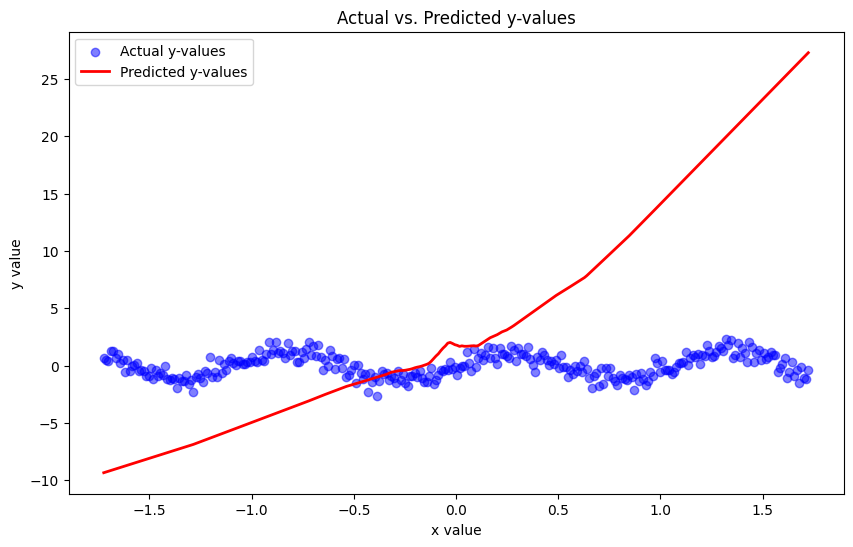

In [90]:
#check model dist without training

untrained_model = BNN(input_features=1, hidden_features1=64, hidden_features2=32, output_features=1)
untrained_model.sample()
untrained_y_est = untrained_model(x)


x_np = x.detach().numpy().flatten()  # Flatten in case x is 2D with one feature
y_np = y.detach().numpy().flatten()  # Actual y-values
y_est_np = untrained_y_est.detach().numpy().flatten()  # Predicted y-values by the model

# Sorting x and associated y values for better visualization, especially for the sine curve
sorted_indices = x_np.argsort()
x_sorted = x_np[sorted_indices]
y_sorted = y_np[sorted_indices]
y_est_sorted = y_est_np[sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_sorted, y_sorted, color='blue', alpha=0.5, label='Actual y-values')
plt.plot(x_sorted, y_est_sorted, color='red', linewidth=2, label='Predicted y-values')
plt.title('Actual vs. Predicted y-values')
plt.xlabel('x value')
plt.ylabel('y value')
plt.legend()
plt.show()

In [20]:
model = BNN(input_features=1, hidden_features1=64, hidden_features2=32, output_features=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

logP_values, logQ_values, ELBO_values, index_values = [], [], [], []

for e in range(epochs):
    optimizer.zero_grad()
    model.sample()  # Sample new model parameters
    y_est = model(x)  # Obtain model predictions
    logP = model.logp(y_est, y)  # Calculate log likelihood
    logQ = model.logq()  # Calculate log probability of the parameters (KL divergence)
    elbo = logP - logQ  # Evidence Lower BOund
    loss = -elbo  # Negate since we want to maximize ELBO
    loss.backward()
    optimizer.step()

    logP_values.append(logP.item())
    logQ_values.append(-logQ.item())
    ELBO_values.append(-loss.item())  
    index_values.append(e)

    if (e+1) % 100 == 0:
        print(f'Epoch {e+1}, Loss = {loss.item()}')
        mean_prediction = y_est.mean().item()
        current_variance = torch.exp(model.log_variance).item()
        print(f'Epoch {e+1}, Loss = {loss.item()}, Mean Prediction = {mean_prediction}, Current Variance = {current_variance}')


Epoch 100, Loss = 12064.744140625
Epoch 100, Loss = 12064.744140625, Mean Prediction = 0.8089951872825623, Current Variance = 0.14219564199447632
Epoch 200, Loss = 18454.4609375
Epoch 200, Loss = 18454.4609375, Mean Prediction = -0.8837293386459351, Current Variance = 0.14500099420547485
Epoch 300, Loss = 108592.9609375
Epoch 300, Loss = 108592.9609375, Mean Prediction = -5.204892158508301, Current Variance = 0.14828231930732727
Epoch 400, Loss = 19216.16015625
Epoch 400, Loss = 19216.16015625, Mean Prediction = 0.633170485496521, Current Variance = 0.1521628350019455
Epoch 500, Loss = 11366.48828125
Epoch 500, Loss = 11366.48828125, Mean Prediction = -2.019503116607666, Current Variance = 0.15631616115570068
Epoch 600, Loss = 10131.0693359375
Epoch 600, Loss = 10131.0693359375, Mean Prediction = -0.7593267560005188, Current Variance = 0.16058912873268127
Epoch 700, Loss = 11990.220703125
Epoch 700, Loss = 11990.220703125, Mean Prediction = -2.195330858230591, Current Variance = 0.1651

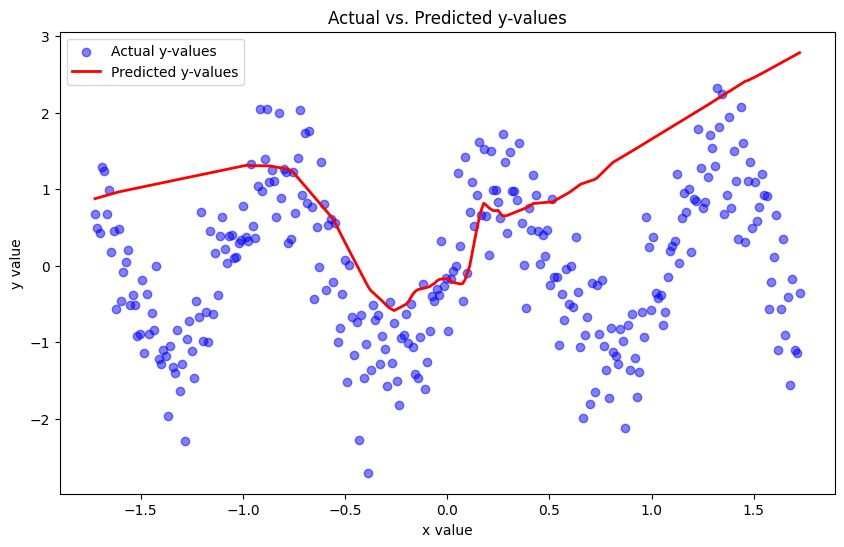

In [87]:
model.sample()
y_est = model(x)


x_np = x.detach().numpy().flatten()  
y_np = y.detach().numpy().flatten()  
y_est_np = y_est.detach().numpy().flatten()



# Sorting x and associated y values for better visualization, especially for the sine curve
sorted_indices = x_np.argsort()
x_sorted = x_np[sorted_indices]
y_sorted = y_np[sorted_indices]
y_est_sorted = y_est_np[sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_sorted, y_sorted, color='blue', alpha=0.5, label='Actual y-values')
plt.plot(x_sorted, y_est_sorted, color='red', linewidth=2, label='Predicted y-values')
plt.title('Actual vs. Predicted y-values')
plt.xlabel('x value')
plt.ylabel('y value')
plt.legend()
plt.show()


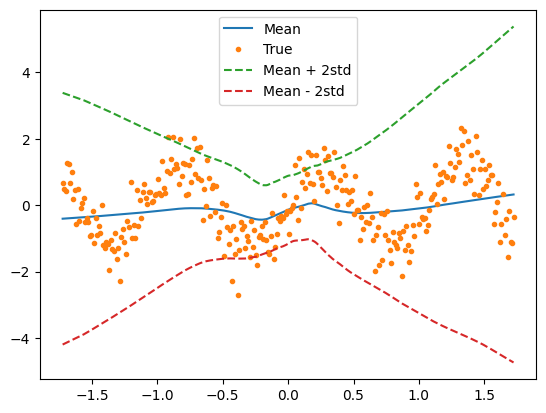

In [88]:
#plotting 

all_y_pred = []
for i in range(100):
    model.sample()
    y_pred = model(x.float())
    all_y_pred.append(y_pred.detach().numpy())  # store the model prediction

all_y_pred = np.array(all_y_pred)

#Calculate the mean and standard deviation of all_y_pred
mean_y_pred = np.mean(all_y_pred, axis=0)
std_y_pred = np.std(all_y_pred, axis=0)

#Plot the mean of all_y_pred
plt.plot(x, mean_y_pred, "-",label='Mean')
plt.plot(x, y.numpy(), ".", label='True')
plt.plot(x, mean_y_pred + 2*std_y_pred, "--", label='Mean + 2std')
plt.plot(x, mean_y_pred - 2*std_y_pred, "--", label='Mean - 2std')
plt.legend()
plt.show()